# Purpose

# Import packages

In [3]:
using Pkg
Pkg.status()

Status `D:\Utilizador HDD\Google Drive\02-Projects\Notebooks-Research\Statistics\Project.toml`
  [a93c6f00] DataFrames v1.6.1
⌃ [31c24e10] Distributions v0.25.108
  [38e38edf] GLM v1.9.0
  [09f84164] HypothesisTests v0.11.0
⌃ [91a5bcdd] Plots v1.40.4
  [295af30f] Revise v3.5.15
  [3eaba693] StatsModels v0.7.3
  [f3b207a7] StatsPlots v0.15.7
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [4]:
using Random
using Revise
using Distributions
using Plots.PlotMeasures
using StatsPlots
using DataFrames
using Printf
using GLM
using StatsModels

In [5]:
includet("../utils/structs/linear_regressions.jl")
includet("../utils/functions/model_utils.jl")

# Generate some sample data for the regressions

In [6]:
rng = Random.seed!(1)

TaskLocalRNG()

In [7]:
n_total = 20

data_growth = DataFrame(; age=[13:(n_total/2+12); 13:(n_total/2+12)],
    sex=repeat(["male", "female"], inner=Int(n_total / 2)),
    weight=[range(100, 155; length=Int(n_total / 2)); range(100, 125; length=Int(n_total / 2))] .+ 2 * randn(rng, n_total))
data_growth

Row,age,sex,weight
,Float64,String,Float64
1,13.0,male,100.124
2,14.0,male,106.668
3,15.0,male,111.031
4,16.0,male,118.427
5,17.0,male,126.616
6,18.0,male,127.402
7,19.0,male,137.019
8,20.0,male,144.509
9,21.0,male,143.308


In [8]:
data_male = filter(:sex => s -> s == "male", data_growth)
data_female = filter(:sex => s -> s == "female", data_growth);

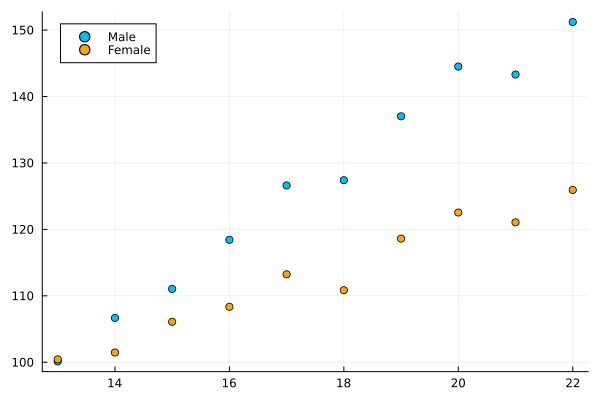

In [9]:
scatter(
    data_male[:, :age],
    data_male[:, :weight],
    markercolor="deepskyblue",
    label="Male"
)

scatter!(
    data_female[:, :age],
    data_female[:, :weight],
    markercolor="orange",
    label="Female"
)

# Simple linear regression with GLM package

In [8]:
ols = lm(@formula(weight ~ age + sex), data_growth)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

weight ~ 1 + age + sex

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  37.6843     6.76277    5.57    <1e-04   23.4161    51.9525
age           4.29547    0.376436  11.41    <1e-08    3.50126    5.08968
sex: male    13.7768     2.16246    6.37    <1e-05    9.21444   18.3392
────────────────────────────────────────────────────────────────────────

In [9]:
data_growth[!, "predictions"] = predict(ols)

20-element Vector{Float64}:
 107.30225826809283
 111.59773095787574
 115.89320364765868
 120.18867633744159
 124.4841490272245
 128.77962171700742
 133.07509440679033
 137.37056709657327
 141.66603978635618
 145.9615124761391
  93.52542576580186
  97.82089845558477
 102.11637114536771
 106.41184383515062
 110.70731652493353
 115.00278921471644
 119.29826190449936
 123.5937345942823
 127.88920728406521
 132.18467997384812

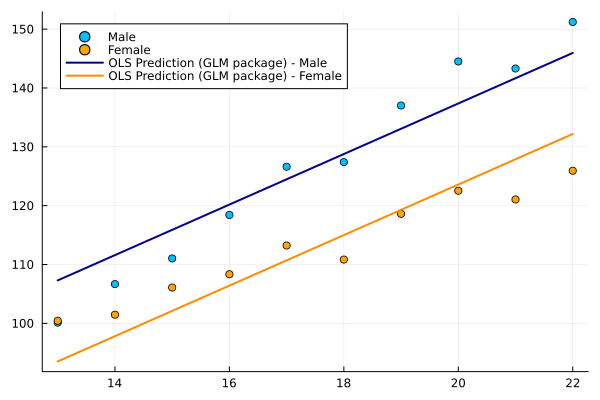

In [10]:
scatter(
    data_male[:, :age],
    data_male[:, :weight],
    markercolor="deepskyblue",
    label="Male"
)

scatter!(
    data_female[:, :age],
    data_female[:, :weight],
    markercolor="orange",
    label="Female"
)

predictions = predict(ols)

plot!(
    filter(:sex => n -> n == "male", data_growth)[:, :age],
    filter(:sex => n -> n == "male", data_growth)[:, :predictions],
    linecolor="darkblue",
    linewidth=2,
    label="OLS Prediction (GLM package) - Male"
)

plot!(
    filter(:sex => n -> n == "female", data_growth)[:, :age],
    filter(:sex => n -> n == "female", data_growth)[:, :predictions],
    linecolor="darkorange",
    linewidth=2,
    label="OLS Prediction (GLM package) - Female"
)

- Note that with a simple linear model the slopes are not allowed to be different and then the data does not seem to fit as well as it should
- We should try, for example, a mixed model

# Hand made

In [11]:
@doc LinearModelOLS

```
LinearModelOLS(formula::FormulaTerm, data::DataFrames.DataFrame)
```

Compute a Multiple Linear Regression

# Method

  * The parameters are estimated via Ordinary Least Squares (OLS)

OLS is an analytical solution that is equivalent to the MLE for a certain type  of linear regression:

  * The model is correctly specified:

      * We have not omitted important variables in the model (underfitting the data)
      * We do not have redundant variables in the model (overfitting the data)
      * The necessary transformations of the variables are applied (e.g. to linearize the relation to the response variable in the case of linear regressions)
      * We do not have outliers in the residuals of the model
  * The residuals are independent and identically distributed
  * The explanatory variables are not correlated with anything but the response variable

The OLS equations are derived from minimizing the Sum of Squared Errors (SSE) (see proof [here](https://openforecast.org/sba/OLS.html))

For the linear regression, the OLS estimator produces the Best Linear Unbiased Estimates (BLUE),  as shown by the Gauss Markov theorem.  Explanation [here](https://www.statlect.com/fundamentals-of-statistics/Gauss-Markov-theorem).


In [46]:
ols_hand_normal = LinearModelOLS(@formula(weight ~ 1 + age + sex), data_growth, "normal")

OLS Linear Regression Model

Formula:  weight ~ 1 + age + sex


   Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.   Std.Error         t      pval            95% CI
─────────────────────────────────────────────────────────────────────────────
      Intercept:    37.684        6.76      5.57 3.371e-05    [23.42, 51.95]
            age:     4.295        0.38     11.41 2.165e-09       [3.5, 5.09]
            sex:    13.777        2.16      6.37 6.968e-06     [9.21, 18.34]
─────────────────────────────────────────────────────────────────────────────


In [45]:
ols_hand_qr = LinearModelOLS(@formula(weight ~ 1 + age + sex), data_growth, "QR")

OLS Linear Regression Model

Formula:  weight ~ 1 + age + sex


   Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.   Std.Error         t      pval            95% CI
─────────────────────────────────────────────────────────────────────────────
      Intercept:    37.684        6.76      5.57 3.371e-05    [23.42, 51.95]
            age:     4.295        0.38     11.41 2.165e-09       [3.5, 5.09]
            sex:    13.777        2.16      6.37 6.968e-06     [9.21, 18.34]
─────────────────────────────────────────────────────────────────────────────


In [44]:
ols_hand_svd = LinearModelOLS(@formula(weight ~ 1 + age + sex), data_growth, "SVD")

OLS Linear Regression Model

Formula:  weight ~ 1 + age + sex


   Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.   Std.Error         t      pval            95% CI
─────────────────────────────────────────────────────────────────────────────
      Intercept:    37.684        6.76      5.57 3.371e-05    [23.42, 51.95]
            age:     4.295        0.38     11.41 2.165e-09       [3.5, 5.09]
            sex:    13.777        2.16      6.37 6.968e-06     [9.21, 18.34]
─────────────────────────────────────────────────────────────────────────────


In [13]:
ols

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

weight ~ 1 + age + sex

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  37.6843     6.76277    5.57    <1e-04   23.4161    51.9525
age           4.29547    0.376436  11.41    <1e-08    3.50126    5.08968
sex: male    13.7768     2.16246    6.37    <1e-05    9.21444   18.3392
────────────────────────────────────────────────────────────────────────

- The coefficients match the GLM package coefficients
- With this small dataset we don't see performance differences between the methods after initial compilation
- With the nature of this dataset we also don't see the problems that the normal equation solver may have inverting the matrix X

## Plot the predictions

In [22]:
data_growth[!, "predictions"] = predict(ols)
data_growth[!, "hand_predictions"] = hand_predict(ols_hand)

20-element Vector{Float64}:
 107.3022582680929
 111.59773095787578
 115.89320364765867
 120.18867633744158
 124.48414902722446
 128.77962171700733
 133.07509440679024
 137.37056709657313
 141.666039786356
 145.96151247613892
  93.52542576580191
  97.8208984555848
 102.11637114536768
 106.41184383515059
 110.70731652493347
 115.00278921471636
 119.29826190449927
 123.59373459428215
 127.88920728406504
 132.18467997384795

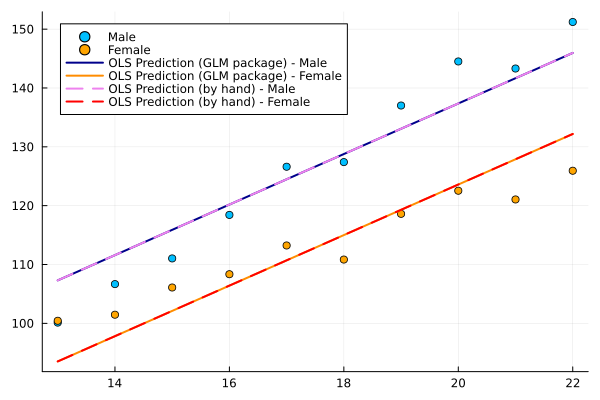

In [29]:
scatter(
    data_male[:, :age],
    data_male[:, :weight],
    markercolor="deepskyblue",
    label="Male"
)

scatter!(
    data_female[:, :age],
    data_female[:, :weight],
    markercolor="orange",
    label="Female"
)

plot!(
    filter(:sex => n -> n == "male", data_growth)[:, :age],
    filter(:sex => n -> n == "male", data_growth)[:, :predictions],
    linecolor="darkblue",
    linewidth=2,
    label="OLS Prediction (GLM package) - Male"
)

plot!(
    filter(:sex => n -> n == "female", data_growth)[:, :age],
    filter(:sex => n -> n == "female", data_growth)[:, :predictions],
    linecolor="darkorange",
    linewidth=2,
    label="OLS Prediction (GLM package) - Female"
)

plot!(
    filter(:sex => n -> n == "male", data_growth)[:, :age],
    filter(:sex => n -> n == "male", data_growth)[:, :hand_predictions],
    linecolor="violet",
    linewidth=2,
    linestyle=:dash,
    label="OLS Prediction (by hand) - Male"
)

plot!(
    filter(:sex => n -> n == "female", data_growth)[:, :age],
    filter(:sex => n -> n == "female", data_growth)[:, :hand_predictions],
    linecolor="red",
    linewidth=2,
    linestyle=:dash,
    label="OLS Prediction (by hand) - Female"
)

- The prediction function that takes the coefficients and multiplies the data (adding the intercept) also matches the GLM package predictions

## Check other parameters

In [30]:
println(ols_hand.SST)
println(ols_hand.SSR)
println(ols_hand.SSE)
println(ols_hand.R²)

4390.914826201254
3993.4346977116743
397.48012848957995
0.8988268927704278


In [31]:
println(ols_hand.coefs)

Dict{String, Real}("Intercept" => 37.68428079862429, "sex" => 13.776832502290981, "age" => 4.295472689782893)


# Explore the breakdown of the OLS assumptions